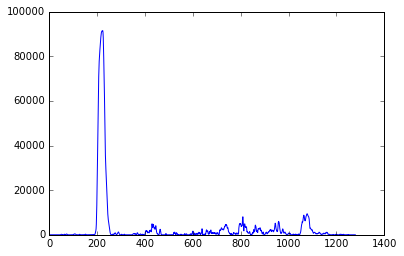

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


binary_warped = cv2.imread('./output_images/unwarped_binary_test1.jpg')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)

# take a histogram along all the columns in the lower half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()


In [2]:
# Create an output image to draw on and  visualize the result, thus stacked into rgb channels
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines

midpoint = histogram.shape[0]//2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = binary_warped.shape[0]//nwindows

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


In [4]:
# Step through the windows one by one
for window in range(nwindows):
	# Identify window boundaries in x and y (and right and left)
	win_y_low = binary_warped.shape[0] - (window+1)*window_height
	win_y_high = binary_warped.shape[0] - window*window_height
	win_xleft_low = leftx_current - margin
	win_xleft_high = leftx_current + margin
	win_xright_low = rightx_current - margin
	win_xright_high = rightx_current + margin

	# Draw the windows on the visualization image
	cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
	cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

	# Identify the nonzero pixels in x and y within the window
	good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
	good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

	# Append these indices to the lists
	left_lane_inds.append(good_left_inds)
	right_lane_inds.append(good_right_inds)

	# If you found > minpix pixels, recenter next window on their mean position
	if len(good_left_inds) > minpix:
		leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

	if len(good_right_inds) > minpix: 
		rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

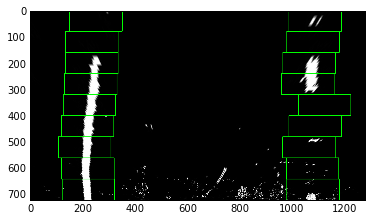

In [6]:
plt.imshow(out_img)
plt.show()

In [8]:
#good_left_inds
good_left_inds

array([   0,    1,    2, ..., 6662, 6663, 6664])

In [10]:
#left_lane_inds
left_lane_inds


NameError: name 'size' is not defined

In [11]:
#size
left_lane_inds.shape

(38258,)

In [12]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

ValueError: zero-dimensional arrays cannot be concatenated

In [15]:
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

In [17]:
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [18]:
# For Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

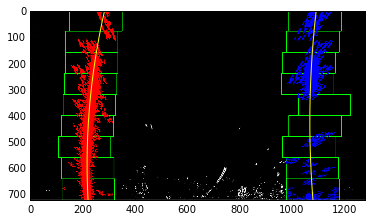

In [19]:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [23]:
# A_left = left_fit[0], B_left = left_fit[1], C_left = left_fit[2]
# A_right = right_fit[0], B_right = right_fit[1], C_right = right_fit[2]
# according to equation for radius of curvature 
y_eval = out_img.shape[0]
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print('left_curverad: {}; right_curverad: {}'.format(left_curverad, right_curverad))

left_curverad: 2582.2104174794626; right_curverad: 3753.462475859723


In [29]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    """
    Draw the found lane lines onto a binary warped image, then unwarp
    and overlay on the original image.
    
    binary_warped
    Minv
    left_fitx
    right_fitx
    ploty
    """
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result


In [33]:
undistorted_img = cv2.imread('output_images/test1_undist.jpg')
undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

import pickle
# read calibration matrix and distortion coefficeint
dist_pickle = pickle.load( open("./warp_pickle.p", "rb"))
Minv = dist_pickle["Minv"]


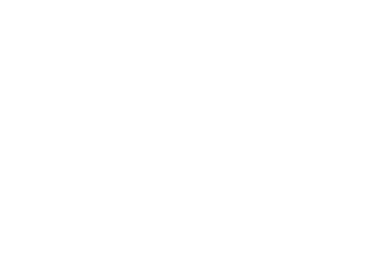

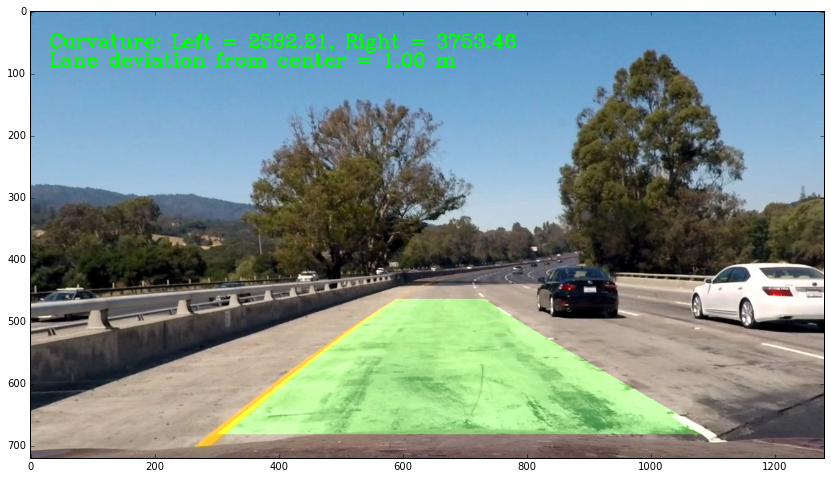

In [34]:
result = draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad, 1)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()
plt.axis("off");
#write_image(result, "output_images/result2.jpg")

In [26]:
binary_warped.shape

(720, 1280)

In [28]:
ploty.shape

(720,)